In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from matplotlib import gridspec

import numpy as np
import scipy.sparse as sp
import numpy.linalg as la

def slerp(p0, p1, t):
        omega = np.arccos(np.dot(p0/np.linalg.norm(p0), p1/np.linalg.norm(p1)))
        so = np.sin(omega)
        return np.sin((1.0-t)*omega) / so * p0 + np.sin(t*omega)/so * p1

def drawSetup(subfig, A, B, C0, C1, mindist, fudgeX=2, fudgeY_pos=2,fudgeY_neg=8):
    subfig.set_aspect('equal')
    fig = subfig
    
    # Set up plot size
    subfig.set_xlim((np.min([A[0], B[0]])-fudgeX,np.max([A[0], B[0]])+fudgeX))
    subfig.set_ylim((np.min([A[1], B[1]])-fudgeY_neg,np.max([A[1], B[1]])+fudgeY_pos))

    # Draw People Positions
    subfig.scatter([A[0], B[0]],[A[1], B[1]],c="red",linewidths=0)
    line_AB = plt.Line2D([A[0], B[0]],[A[1], B[1]], c="black",alpha=0.3)
    subfig.add_artist(line_AB)

    # Draw Circles    
    circle_PA_1=plt.Circle(A,min_dist,color='g',alpha=0.5)
    circle_PB_1=plt.Circle(B,min_dist,color='g',alpha=0.5)
    
    subfig.add_artist(circle_PA_1)
    subfig.add_artist(circle_PB_1)

    subfig.annotate(s="A", xy=A[0:2],xytext=(3,4),textcoords="offset points")
    subfig.annotate(s="B", xy=B[0:2],xytext=(3,4),textcoords="offset points")
    
    # Draw Camera positions
    subfig.scatter([C0[0],C1[0]],[C0[1],C1[1]],c="blue",linewidths=0)
    subfig.annotate(s="C0", xy=C0[0:2],xytext=(3,4),textcoords="offset points")
    subfig.annotate(s="C1", xy=C1[0:2],xytext=(3,4),textcoords="offset points")


In [ ]:
min_dist = 1                    # let's set a minimum distance of 1m
A  = np.array([0,0,0])     # person A position
B  = np.array([6,0,0])     # person B position
C0 = np.array([-1.1,-0.2,0])  # Starting camera position is *outside* of PA_1
C1 = np.array([2.1,-0.2,0])    # Ending camera position

def sigmoid_blended_trajectory(A, B, C0, C1, min_dist, blendOptimizer):
    
    '''
    This function sets up the problem, and passes in the individual trajectories
    to the given blendOptimizer function. 
    
    blendOptimizer must return a blended trajectory as well as a blending function.
    
    We then draw it all pretty.
    '''
    
    # Set up interpolation vector
    u = np.c_[np.linspace(0,1)]

    # Set up the distance components of sigmaA, sigmaB
    dA0 = la.norm(C0 - A)
    dA1 = la.norm(C1 - A)
    dB0 = la.norm(C0 - B)
    dB1 = la.norm(C1 - B)

    dA = np.linspace(dA0, dA1)
    dB = np.linspace(dB0, dB1)

    # Set up the vantage vector components of sigmaA, sigmaB
    vA0 = (C0 - A) / dA0
    vA1 = (C1 - A) / dA1
    vB0 = (C0 - B) / dB0
    vB1 = (C1 - B) / dB1

    vA = np.apply_along_axis(lambda u : slerp(vA0,vA1,u), axis=1, arr=u)
    vB = np.apply_along_axis(lambda u : slerp(vB0,vB1,u), axis=1, arr=u)

    # Set up sigmaA, sigmaB, sigma
    sigmaA = A + dA[:,np.newaxis] * vA
    sigmaB = B + dB[:,np.newaxis] * vB

    sigmaAvg = (sigmaA + sigmaB)/2
    wA, sigmaBlended = blendOptimizer(u, sigmaA, sigmaB, A, B)

    # Drawing Code
    
    pylab.rcParams['figure.figsize'] = 16, 8
    gs = gridspec.GridSpec(1, 2, width_ratios=[1,1], height_ratios=[1]) 
    fig = plt.figure()
    f1 = fig.add_subplot(gs[0])
    f2 = fig.add_subplot(gs[1])

    drawSetup(f1, A, B, C0, C1, min_dist,fudgeY_neg=(4+min_dist),fudgeY_pos=(4+min_dist),fudgeX=1+min_dist)
    f1.plot(sigmaA[:,0],       sigmaA[:,1],       c="green")
    f1.plot(sigmaB[:,0],       sigmaB[:,1],       c="blue")
    f1.plot(sigmaAvg[:,0],     sigmaAvg[:,1],     c="red")
    f1.plot(sigmaBlended[:,0], sigmaBlended[:,1], c="purple")

    f1.set_title("World Space Trajectories")

    sA_legend = mpatches.Patch(color="green", label="sigmaA")
    sB_legend = mpatches.Patch(color="blue", label="sigmaB")
    SA_legend  = mpatches.Patch(color="red", label="sigma Averaged")
    SW_legend  = mpatches.Patch(color="purple", label="sigma Blended")

    f1.legend(handles=[sA_legend,sB_legend,SA_legend,SW_legend])
    
    
    f2.plot(wA)
    f2.set_title("Weighing function")


In [ ]:
def blendOptimizer_simple_sigmoid_blend(u, sigma_i, sigma_j, i, j):
    '''
    This blending function implements the a soft version of the constraints
    represented in notebook "09 - NJ" directly: we are not minimizing anything explicitly.
    '''
    from scipy.special import expit

    scale = 6

    def silly_map(sigmas):
        sigmaiu = sigmas[0:3]
        sigmaju = sigmas[3:6]

        w1 = expit(-scale*(la.norm(sigmaju - i) - min_dist))/2 + 0.5 #weight one goes from 1 to 0.5
        w2 = expit(scale*(la.norm(sigmaiu - j) - min_dist))
        return w1*w2

    blend = np.apply_along_axis(silly_map, axis=1, arr=np.c_[sigma_i, sigma_j]) 
    sigmaBlended = (blend[:,np.newaxis]*sigma_i + (1-blend)[:,np.newaxis]*sigma_j)
    
    return (blend, sigmaBlended)

sigmoid_blended_trajectory(A, B, C0, C1, min_dist,blendOptimizer_simple_sigmoid_blend)

In [ ]:

from scipy import interpolate

def blendOptimizer_silly_by_hand(u, sigma_i, sigma_j, i, j):
    f = interpolate.interp1d([0,0.25,0.5,0.75,1],[0.5,1,0.5,1,0.5])
    blend = f(u)
    sigmaBlended = (blend*sigma_i + (1-blend)*sigma_j)
    
    return (blend, sigmaBlended)

sigmoid_blended_trajectory(A, B, C0, C1, min_dist,blendOptimizer_silly_by_hand)

# Blending function properties and constraints

We want to find $w_A(\vec{\sigma}_A,\vec{\sigma}_B,u)$ such that 

$$
\vec{\sigma}(u) = w(\vec{\sigma}_A,\vec{\sigma}_B,u)\cdot\vec{\sigma}_A(u) \;\, + \;\, (1 - w_A(\vec{\sigma}_A,\vec{\sigma}_B,u))\cdot\vec{\sigma}_B(u)
$$

The constraints on $w(\vec{\sigma}_A,\vec{\sigma}_B,u)$ and on $\vec{\sigma}(u)$ are:

* $w_A() \in (0,1) $
* $w_A()$ is C4 continuous
* $\|\vec{\sigma}(u) - A\| \geq d_{min}$
* $\|\vec{\sigma}(u) - B\| \geq d_{min}$

And, we want to minimize the error from the 0.5 in a smooth way, and minimize the bending of the curve.

* Minimize $\int_{u} (w_a(u) - 0.5)^2$
* Minimize $\int_{u} (\frac{d^4w_a(u)}{dt^4})^2$ as a proxy for bending energy.


Can we build this up in a nice way piece by piece?

## Direction 1:  We discretize, with decision variables being $w_A$ samples


### Warmup 

Just to warm up, lets solve the toy problem in section 3.2 of the [SNOPT7 User's Guide](https://web.stanford.edu/group/SOL/guides/sndoc7.pdf)

In [ ]:
from optimize.snopt7 import SNOPT_solver

def sntoya_objF(status,x,needF,needG,cu,iu,ru):
    F = np.array([                      x[1], # objective row
                   x[0]**2        + 4.0*x[1]**2,
                  (x[0] - 2.0)**2 +     x[1]**2 ])
    return status, F

inf   = 1.0e20

snopt = SNOPT_solver()

snopt.setOption('Verbose',True)
snopt.setOption('Solution print',True)
snopt.setOption('Print file','sntoya.out')


# Either dtype works, but the names for x and F have to be of
# the correct length, else they are both ignored by SNOPT:
xNames  = np.array([ '      x0', '      x1' ])
FNames  = np.array([ '      F0', '      F1', '      F2' ],dtype='c')

x0      = np.array([ 1.0, 1.0 ])

xlow    = np.array([ 0.0, -inf])
xupp    = np.array([ inf,  inf])

Flow    = np.array([ -inf, -inf, -inf ])
Fupp    = np.array([  inf,  4.0,  5.0 ])

ObjRow  = 1

# We first solve the problem without providing derivative info
snopt.snopta(name='sntoyaF',x0=x0,xlow=xlow,xupp=xupp,
             Flow=Flow,Fupp=Fupp,ObjRow=ObjRow,
             usrfun=sntoya_objF,xnames=xNames,Fnames=FNames)

print "Solution:"
print snopt.x

# Test 1: Simplest thing ever, get SNOPT running with (0,1) constraints on X

Let's express the following very simple problem.

*Marc: Resorting to optimization is always a failure since I like to find a more elegant solution, but there's often no way of doing that.*

We **discretize** the blending function, by sampling from $(0,1)$. Our decision variables is the value $w_A(i)$ where $i = [0,1,\cdots]$

$$
\begin{equation*}
\begin{aligned}
& \underset{x}{\text{minimize}}
& & \Sigma_i(w_A(i) - 0.5)^2 \\
& \text{subject to}
& & w_A(i) \in (0,1) , \; i = 1, \ldots, n.\\
&&& w_A(n/2) = 1
\end{aligned}
\end{equation*}
$$

We have to install [SNOPT](https://www.dropbox.com/sh/4phj28k06w7o0gt/AABK_WO6O3RXerIF9bbba_Bia?dl=0) and [Snopt Python](https://github.com/snopt/snopt-python).
Working from [snopt-python's toy A example.](https://github.com/snopt/snopt-python/blob/master/examples/sntoya.py)

We have to write this into the proper **NP** form. See Chapter 1 of the [SNOPT User's Guide](https://web.stanford.edu/group/SOL/guides/sndoc7.pdf)

$$
\begin{equation*}
\begin{aligned}
& \underset{\vec{x}}{\text{minimize}}
& & f_0(\vec{x}) \\
& \text{subject to} & & l \leq \left(
\begin{array}{c}
\vec{x}\\
f(\vec{x})\\
A_l\vec{x}\\
\end{array}
\right) \leq u
\end{aligned}
\end{equation*}
$$

Which we break up into components:

1. Define $\vec{x}$, the vector of decision variables.
2. Define $l_x$ and $u_x$ such that $l_x \leq \vec{x} \leq u_x$
3. Define $F(\vec{x})$ as $\left(
\begin{array}{c}
f_0(\vec{x})\\
f_1(\vec{x})\\
\cdots\\
f_m(\vec{x})\\
\end{array}
\right)$ where $f_0(\vec{x})$ is the objective function to minimize, and $f_i(\vec{x})$ are constraint functions.
4. Define $l_F$ and $u_F$ such that $l_F \leq F(\vec{x}) \leq u_F$

In [ ]:
from optimize.snopt7 import SNOPT_solver
import numpy as np

inf = 1.0e20

snopt = SNOPT_solver()
snopt.setOption('Verbose',False)
snopt.setOption('Solution print',True)
snopt.setOption('Print file','blend_test1.out')

nsamples = 50

# 1. Set up decision variables
x0 = np.array([-1.0]*nsamples)

# 2. Set up the bounds on x
low_x = np.array([0.0]*nsamples)
upp_x = np.array([1.0]*nsamples)

# 3. Set up the objective function
def blend_test1_objF(status,x,needF,needG,cu,iu,ru):
    F = np.array([np.sum((x - 0.5)**2)]) # objective row
    return status, F

# 4. Set up bounds on F
low_F    = np.array([ -inf])
upp_F    = np.array([  inf])

# 5. Lets set up an equality constraint on one of the centerpoints
low_x[nsamples/2] = 1.0

# Matrix uses fortran numbering or something
ObjRow = 1

# We first solve the problem without providing derivative info
snopt.snopta(name='blend_test1',x0=x0,xlow=low_x,xupp=upp_x,
             Flow=low_F,Fupp=upp_F,ObjRow=ObjRow,
             usrfun=blend_test1_objF)

plt.plot(snopt.x)
plt.ylim([0,1])
plt.title("Resulting optimized X values")

In [ ]:
def precalculated_blendOptimized(u, sigma_i, sigma_j, i, j):
    blend = np.c_[snopt.x]
    sigmaBlended = (blend*sigma_i + (1-blend)*sigma_j)
    
    return (blend, sigmaBlended)

sigmoid_blended_trajectory(A, B, C0, C1, min_dist,blendOptimizer=precalculated_blendOptimized)

# Test 2: Express C4 Continuity Constraints and a single simple obstacle

Let's expand on the previous problem.

We **discretize** the blending function $w(i)$ as a sequence of samples. Each sample is the value of $w(i)$ and its first 5 derivatives.

That is, our decision variables at each sample is:

$$
\begin{align}
\mathbf{d}_i = & \left(
\begin{array}{r}
w_i &
\frac{dw_i}{dt} & 
\frac{d^2w_i}{dt^2} & 
\frac{d^3w_i}{dt^3} &
\frac{d^4w_i}{dt^4} &
\frac{d^5w_i}{dt^5} &
\end{array}
\right) \\
= & \left(
\begin{array}{r}
w_i &
\dot{w}_i & 
\ddot{w}_i & 
\dddot{w}_i & 
\ddddot{w}_i & 
v_i & 
\end{array}
\right)
\end{align}
$$

Dor convenience, we will define $w(i)$ and only its first 4 derivatives as:

$$
\mathbf{s}_i = \left(
\begin{array}{r}
w_i &
\dot{w}_i & 
\ddot{w}_i & 
\dddot{w}_i & 
\ddddot{w}_i & 
\end{array}
\right)
$$

So our decision variables are the matrix:

$$
\mathbf{D} = \left[
\begin{array}{c}
d_0\\
\cdots\\
d_n
\end{array}
\right]
$$

We write down the following minimization problem:

$$
\begin{equation*}
\begin{aligned}
& \underset{x}{\text{minimize}}
& & \lambda_p\Sigma_i(w_i - 0.5)^2dt + \lambda_s\Sigma_i(\ddddot{w_i})^2dt\\
& \text{subject to}
& & w_i \in (0,1) , \; i = 1, \ldots, n.\\
&&& w_{0} = 0.5 \\
&&& w_{n} = 0.5 \\
&&& w_{n/2} = 1 \\
&&& \mathbf{s}_{i+1} = \mathbf{s}_{i} + (\mathbf{M}\mathbf{s}_i + \mathbf{N}v)dt \\
&&& v_{min} < v < v_{max}
\end{aligned}
\end{equation*}
$$

We rewrite our constraints so that they are all equality to a scalar value. That is:

$$
\mathbf{s}_{i} + (\mathbf{M}\mathbf{s}_i + \mathbf{N}v)dt - \mathbf{s}_{i+1} = 0
$$

where

$$
\begin{array}{r}
\mathbf{M} = \begin{bmatrix}
0&1&0&0&0\\
0&0&1&0&0\\
0&0&0&1&0\\
0&0&0&0&1\\
0&0&0&0&0\\
\end{bmatrix} & 
\mathbf{N} = \begin{bmatrix}
0\\
0\\
0\\
0\\
1\\
\end{bmatrix}
\end{array}
$$

**Notice we now have the following parameters**

* $\lambda_p$ and $\lambda_s$, the relative preference to minimize position or snap. By default, $\lambda_s = \frac{1}{dt^5}$
* $dt$, the size of the timestep between successive samples. This is non-physical and we should "Get rid" of this.
* $v_{min}$ and $v_{max}$, the maximum deviation we allow in the 5th derivative. If this is too large, we can see huge oscillatory behavior in our C4 continuous spline.


In [ ]:
from optimize.snopt7 import SNOPT_solver
import numpy as np
import scipy.sparse    as sp
import time

# Some important parameters here

nsamples = 50
ndims    = 6

dt = 0.01
xdot5_limit = 0.00001

inf = 1.0e20

lambda_snap = 1/dt**5 # snap must be scaled down to be comparable to position.
lambda_pos = 1

# Solver Time!

snopt = SNOPT_solver()
snopt.setOption('Verbose',False)
snopt.setOption('Solution print',True)
snopt.setOption('Print file','blend_test1.out')

# 1. Set up decision variables

x     = np.array([0.5]*nsamples) # Initialize to 0.5
xdot1 = np.array([0.0]*nsamples)
xdot2 = np.array([0.0]*nsamples)
xdot3 = np.array([0.0]*nsamples)
xdot4 = np.array([0.0]*nsamples)
v     = np.array([0.0]*nsamples) # C4 Continuity Control Variable

x0 = np.matrix(np.c_[x,xdot1,xdot2,xdot3,xdot4,v]).A1 # Interleave [x[0],xdot1[0],xdot2[0]...]

# 2. Set up the bounds on x

low_x     = np.array([ 0.0] *nsamples) # X must be greater or equal to 0
low_xdot1 = np.array([ -inf]*nsamples)
low_xdot2 = np.array([ -inf]*nsamples)
low_xdot3 = np.array([ -inf]*nsamples)
low_xdot4 = np.array([ -inf]*nsamples)
low_v     = np.array([ -xdot5_limit]*nsamples) # Bound control variable arbitrarily

low_x[0] = 0.5
low_x[nsamples-1] = 0.5

low_x[nsamples/2] = 1.0 # with one silly constraint
#low_x[nsamples/2 + nsamples/4] = 0.0 # with one silly constraint

xlow = np.matrix(np.c_[low_x,low_xdot1,low_xdot2,low_xdot3,low_xdot4,low_v]).A1 # Interleave [x[0],xdot1[0],xdot2[0]...]

upp_x     = np.array([ 1.0] *nsamples) # X must be greater or equal to 0
upp_xdot1 = np.array([ inf]*nsamples)
upp_xdot2 = np.array([ inf]*nsamples)
upp_xdot3 = np.array([ inf]*nsamples)
upp_xdot4 = np.array([ inf]*nsamples)
upp_v     = np.array([ xdot5_limit]*nsamples) # Bound control variable arbitrarily

upp_x[0] = 0.5
upp_x[nsamples-1] = 0.5
#upp_x[nsamples/2 + nsamples/4] = 0.0

xupp = np.matrix(np.c_[upp_x,upp_xdot1,upp_xdot2,upp_xdot3,upp_xdot4,upp_v]).A1 # Interleave [x[0],xdot1[0],xdot2[0]...]

# 3. Set up the objective function

M = np.array([
        [0,1,0,0,0],
        [0,0,1,0,0],
        [0,0,0,1,0],
        [0,0,0,0,1],
        [0,0,0,0,0]
    ])

N = np.array([0,0,0,0,1])

def blend_test2_objF(status,x,needF,needG,cu,iu,ru):
    
    xM = x.reshape(nsamples,ndims)
    
    ####################
    #    CALCULATE F
    ####################
    
    # our objective is the sum of
    # the L2 norm of our position error away from 0.5
    # the L2 norm of our 4th derivative error away from 0
    obj_pos  = np.sum( (xM[:,0] - 0.5)**2 * dt)
    obj_snap = np.sum( (xM[:,4]      )**2 * dt)  
    objective = lambda_pos * obj_pos + lambda_snap * obj_snap
    #
    continuity_x = np.zeros((nsamples, 5))

    for i in range(nsamples-1):
        si  = xM[i,0:5]
        vi  = xM[i,5  ]
        si1 = xM[i+1,0:5]
        continuity_x[i] = si + (M.dot(si) + N.dot(vi))*dt - si1
   
    continuity_x = np.matrix(continuity_x).A1
        
    F = np.concatenate(
        ([objective],
         continuity_x))

    ####################
    #    CALCULATE G
    ####################
    
    
    
    
    return status, F

# 4. Set up bounds on F

low_F    = np.concatenate(([-inf], np.array([0,0,0,0,0]*nsamples)))
upp_F    = np.concatenate(([ inf], np.array([0,0,0,0,0]*nsamples)))

# Matrix uses fortran numbering or something
ObjRow = 1



# We first solve the problem without providing derivative info
a = time.time()

snopt.snopta(name='blend_test2',x0=x0,xlow=xlow,xupp=xupp,
             Flow=low_F,Fupp=upp_F,ObjRow=ObjRow,
             usrfun=blend_test2_objF)
b = time.time()

print "Solved in %.4fs" % (b - a)

print "Value of objective function: %.8f" % snopt.F[0]

pylab.rcParams['figure.figsize'] = 12, 24
gs = gridspec.GridSpec(6, 1, width_ratios=[1], height_ratios=[1,1,1,1,1,1]) 
fig = plt.figure()
f1 = fig.add_subplot(gs[0])
f2 = fig.add_subplot(gs[1])
f3 = fig.add_subplot(gs[2])
f4 = fig.add_subplot(gs[3])
f5 = fig.add_subplot(gs[4])
f6 = fig.add_subplot(gs[5])

f1.plot(snopt.x[0::6])
f1.set_ylim([0,1])
f1.set_xlim([0,nsamples-1])
f1.set_title("Resulting optimized X values")

f2.plot(snopt.x[1::6])
f2.set_ylim()
f2.set_xlim([0,nsamples-1])
f2.set_title("Resulting optimized Xdot1 (Speed) values")

f3.plot(snopt.x[2::6])
f3.set_ylim()
f3.set_xlim([0,nsamples-1])
f3.set_title("Resulting optimized Xdot2 (Accel) values")

f4.plot(snopt.x[3::6])
f4.set_ylim()
f4.set_xlim([0,nsamples-1])
f4.set_title("Resulting optimized Xdot3 (Jerk) values")

f5.plot(snopt.x[4::6])
f5.set_ylim()
f5.set_xlim([0,nsamples-1])
f5.set_title("Resulting optimized Xdot4 (Snap) values")

f6.plot(snopt.x[5::6])
f6.set_ylim()
f6.set_xlim([0,nsamples-1])
f6.set_title("Resulting optimized v values")


In [ ]:
def precalculated_blendOptimized(u, sigma_i, sigma_j, i, j):
    blend = np.c_[snopt.x[0::6]]
    sigmaBlended = (blend*sigma_i + (1-blend)*sigma_j)
    
    return (blend, sigmaBlended)

sigmoid_blended_trajectory(A, B, C0, C1, min_dist,blendOptimizer=precalculated_blendOptimized)

In [ ]:
x     = np.array([0.5]*nsamples) # Initialize to 0.5
xdot1 = np.array([0.0]*nsamples)
xdot2 = np.array([0.0]*nsamples)
xdot3 = np.array([0.0]*nsamples)
xdot4 = np.array([0.2]*nsamples)
v     = np.array([0.9]*nsamples) # C4 Continuity Control Variable

x0 = np.matrix(np.c_[x,xdot1,xdot2,xdot3,xdot4,v]) # Interleave [x[0],xdot1[0],xdot2[0]...]

continuity_x = np.zeros((nsamples, 5))

for i in range(nsamples-1):
    si  = xM[0:5,i]
    vi  = xM[5  ,i]
    si1 = xM[0:5,i+1]
    continuity_x[i] = si + (M.dot(si) + N.dot(vi))*dt - si1

F = np.concatenate(
        ([12345],
         np.matrix(continuity_x).A1))
    

low_F    = np.concatenate(([-inf], np.array([0,0,0,0,0]*nsamples)))


# Test 3: Additionally, calculate the Jacobian


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Solved in 0.0456s
Value of objective function: 5.54144912
 lambda_pos: 100.000000, lambda_snap: 100000000.000000, 
 objective: 5.541449, obj_pos: 0.055414, obj_snap: 0.000000


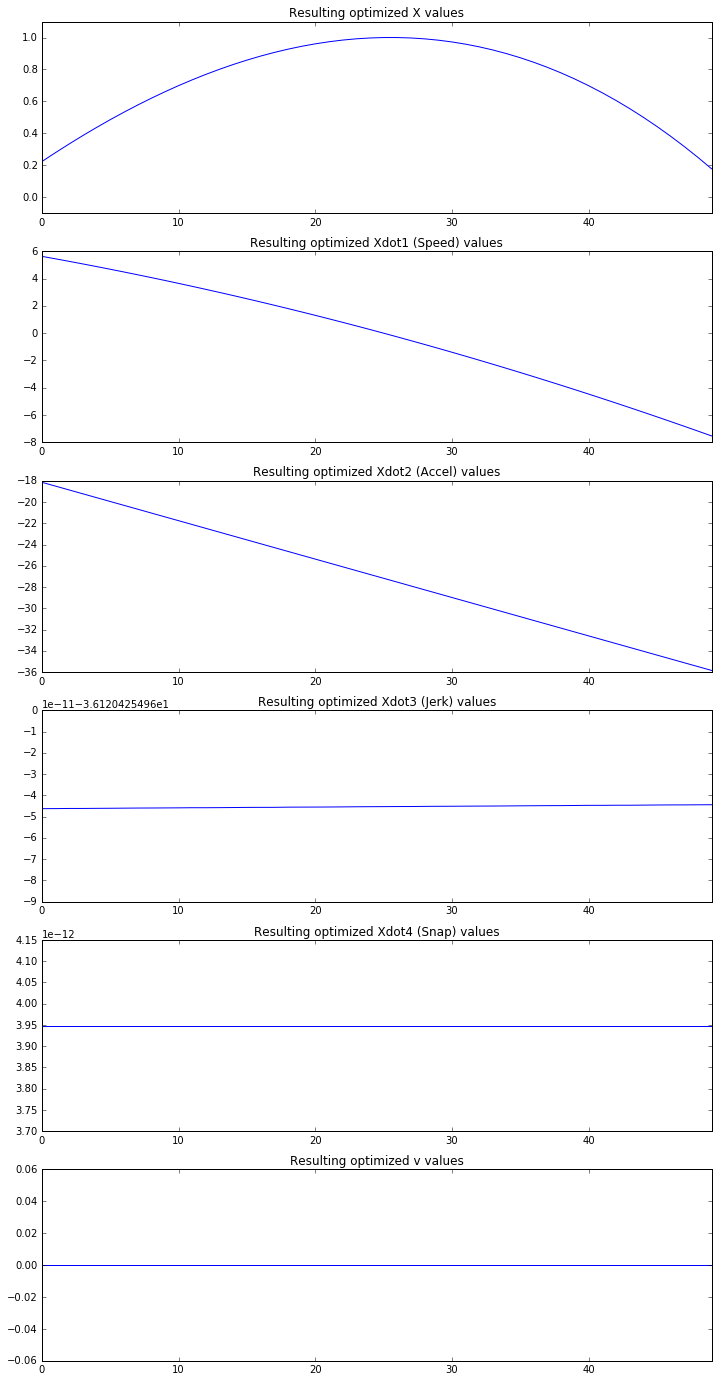

In [97]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from matplotlib import gridspec

import numpy as np
import scipy.sparse as sp
import numpy.linalg as la

import numpy as np
import time
from optimize.snopt7 import SNOPT_solver

# Some important parameters here

nsamples = 50
ndims    = 6
nvars = ndims*nsamples
nconstraints = ((ndims-1)*nsamples) + 1
 

dt = 0.01
xdot5_limit = 0.001

inf = 1.0e20

lambda_snap = (1/dt)**4 # snap must be scaled down to be comparable to position.
lambda_pos = 100

# NOTE: We have this stupid dummy value since snopt-python has a bug.


# Solver Time!

snopt = SNOPT_solver()
snopt.setOption('Verbose',False)
snopt.setOption('Solution print',False)
snopt.setOption('Print file','13_blend_test_3_print.out')
snopt.setOption('Iteration limit',8000)
snopt.setOption('Print level',3)
snopt.setOption('Major optimality',2e-6)

# 
# # snopt.setOption('Linesearch tolerance',0.4)
snopt.setOption('Verify level',3) # Turn to 3 to carefully check gradiants
# snopt.setOption('Print level',3)
# snopt.setOption('Major print level',0)

# 1. Set up decision variables

x     = np.array([0.5]*nsamples) # Initialize to 0.5
xdot1 = np.array([0.0]*nsamples)
xdot2 = np.array([0.0]*nsamples)
xdot3 = np.array([0.0]*nsamples)
xdot4 = np.array([0.0]*nsamples)
v     = np.array([0.0]*nsamples) # C4 Continuity Control Variable

x0 = np.matrix(np.c_[x,xdot1,xdot2,xdot3,xdot4,v]).A1 # Interleave [x[0],xdot1[0],xdot2[0]...]

# 2. Set up the bounds on x

low_x     = np.array([ 0.0] *nsamples) # X must be greater or equal to 0
low_xdot1 = np.array([ -inf]*nsamples)
low_xdot2 = np.array([ -inf]*nsamples)
low_xdot3 = np.array([ -inf]*nsamples)
low_xdot4 = np.array([ -inf]*nsamples)
low_v     = np.array([ -xdot5_limit]*nsamples) # Bound control variable arbitrarily

#low_x[0] = 0.5
#low_x[nsamples-1] = 0.5

low_x[nsamples/2] = 1.0 # with one silly constraint
#low_x[nsamples/2 + nsamples/4] = 1.0 # with one silly constraint

xlow = np.matrix(np.c_[low_x,low_xdot1,low_xdot2,low_xdot3,low_xdot4,low_v]).A1 # Interleave [x[0],xdot1[0],xdot2[0]...]

upp_x     = np.array([ 1.0] *nsamples) # X must be greater or equal to 0
upp_xdot1 = np.array([ inf]*nsamples)
upp_xdot2 = np.array([ inf]*nsamples)
upp_xdot3 = np.array([ inf]*nsamples)
upp_xdot4 = np.array([ inf]*nsamples)
upp_v     = np.array([ xdot5_limit]*nsamples) # Bound control variable arbitrarily

#upp_x[0] = 0.5
#upp_x[nsamples-1] = 0.5
#upp_x[nsamples/2 + nsamples/4] = 1.0

xupp = np.matrix(np.c_[upp_x,upp_xdot1,upp_xdot2,upp_xdot3,upp_xdot4,upp_v]).A1 # Interleave [x[0],xdot1[0],xdot2[0]...]

# 3. Set up the objective function

M = np.array([
        [0,1,0,0,0],
        [0,0,1,0,0],
        [0,0,0,1,0],
        [0,0,0,0,1],
        [0,0,0,0,0]
    ])

N = np.array([0,0,0,0,1])

def grad_function(xM, compute_nonzero_only=False, compute_linear=False):
    # G[row, col]
    # Where each column is a partial derivative with respect to a single variable x_i
    G = np.zeros((nconstraints, nvars))
    obj_col = G[0,:]

    # Set up the jacobian structure of the cost function. 
    # This only impacts the w_i and wdot4_i variables 
    if not compute_nonzero_only:
        obj_col[::6] = 2*dt*lambda_pos*(xM[:,0] - 0.5)
        obj_col[4::6] = 2*dt*lambda_snap*xM[:,4]
    elif not compute_linear:
        obj_col[::6] = 1
        obj_col[4::6] = 1        

    if compute_linear:
        
        stupidcounter = 0
        add_to_fi = 0    
        for fi in range(1,nconstraints-5): # Looping over the objective function
            fi_row = G[fi,:]

            fi += add_to_fi

            fi_row[fi-1] = 1
            fi_row[fi]   = dt
            fi_row[fi+5] = -1

            stupidcounter += 1
            if stupidcounter == 5:
                add_to_fi += 1
                stupidcounter = 0
            
    return G    

def calc_obj(xM):
    # our objective is the sum of
    # the L2 norm of our position error away from 0.5
    # the L2 norm of our 4th derivative error away from 0
    obj_pos  = dt * np.sum( (xM[:,0] - 0.5)**2)
    obj_snap = dt * np.sum( (xM[:,4]      )**2)  
    objective = lambda_pos * obj_pos + lambda_snap * obj_snap
    return (objective, obj_pos, obj_snap)

def blend_test3_objFG(status,x,needF,needG,cu,iu,ru):

    xM = x.reshape(nsamples,ndims)
    
    objective, obj_pos, obj_snap = calc_obj(xM)

    # Evaluate the current continuity constraints
    continuity_x = np.zeros((nsamples, 5))

    for i in range(nsamples-1):
        si  = xM[i,0:5]
        vi  = xM[i,5  ]
        si1 = xM[i+1,0:5]
        continuity_x[i] = si + (M.dot(si) + N.dot(vi))*dt - si1
   
    continuity_x = np.matrix(continuity_x).A1
        
    F = np.concatenate(
        ([objective],
         continuity_x))
        
    G = grad_function(xM)
    
    return status, F, G[G_nonzero_inds]

# 4. Set up bounds on F

low_F    = np.concatenate(([-inf], np.array([0,0,0,0,0]*nsamples)))
upp_F    = np.concatenate(([ inf], np.array([0,0,0,0,0]*nsamples)))

# Matrix uses fortran numbering or something
ObjRow = 1

# Set up the linear and nonlinear structure of the jacobian matrix

xM = x0.reshape(nsamples,ndims)

G = grad_function(xM,compute_nonzero_only=True, compute_linear=False)
G_nonzero_inds           = G.nonzero()

A = grad_function(xM,compute_nonzero_only=True, compute_linear=True)


# We first solve the problem without providing derivative info
a = time.time()

snopt.snopta(name='blend_test3',usrfun=blend_test3_objFG,x0=x0,xlow=xlow,xupp=xupp,
             Flow=low_F,Fupp=upp_F,ObjRow=ObjRow,A=A,G=G)
b = time.time()

print "Solved in %.4fs" % (b - a)

print "Value of objective function: %.8f" % snopt.F[0]

pylab.rcParams['figure.figsize'] = 12, 24
gs = gridspec.GridSpec(6, 1, width_ratios=[1], height_ratios=[1,1,1,1,1,1]) 
fig = plt.figure()
f1 = fig.add_subplot(gs[0])
f2 = fig.add_subplot(gs[1])
f3 = fig.add_subplot(gs[2])
f4 = fig.add_subplot(gs[3])
f5 = fig.add_subplot(gs[4])
f6 = fig.add_subplot(gs[5])

f1.plot(snopt.x[0::6])
f1.set_ylim([-.1,1.1])
f1.set_xlim([0,nsamples-1])
f1.set_title("Resulting optimized X values")

f2.plot(snopt.x[1::6])
f2.set_ylim()
f2.set_xlim([0,nsamples-1])
f2.set_title("Resulting optimized Xdot1 (Speed) values")

f3.plot(snopt.x[2::6])
f3.set_ylim()
f3.set_xlim([0,nsamples-1])
f3.set_title("Resulting optimized Xdot2 (Accel) values")

f4.plot(snopt.x[3::6])
f4.set_ylim()
f4.set_xlim([0,nsamples-1])
f4.set_title("Resulting optimized Xdot3 (Jerk) values")

f5.plot(snopt.x[4::6])
f5.set_ylim()
f5.set_xlim([0,nsamples-1])
f5.set_title("Resulting optimized Xdot4 (Snap) values")

f6.plot(snopt.x[5::6])
f6.set_ylim()
f6.set_xlim([0,nsamples-1])
f6.set_title("Resulting optimized v values")

xM = snopt.x.reshape(nsamples,ndims)

print " lambda_pos: %f, lambda_snap: %f, " % (lambda_pos, lambda_snap)
print " objective: %f, obj_pos: %f, obj_snap: %f" % calc_obj(xM)


### Toy problem from SNOPT

In [ ]:
"""
This is the toy example problem in the SNOPT documentation.
     min         x1
     s.t   .   x1**2 + 4x2**2 <= 4
           (x1-2)**2 +  x2**2 <= 5
            x1 >=0
We define the function F(x):
   F(x)  = [     x1             ]
           [     x1**2 + 4x2**2 ]
           [ (x1-2)**2 +  x2**2 ]
with ObjRow = 1 to indicate the objective.
The Jacobian is:
  F'(x)  = [   1       0  ]   [ 1 0 ]    [   0       0  ]
           [   2x1    8x2 ] = [ 0 0 ]  + [   2x1    8x2 ]
           [ 2(x1-2)  2x2 ]   [ 0 0 ]    [ 2(x1-2)  2x2 ]
                             linear(A)     nonlinear (G)
"""

import numpy           as np
import scipy.sparse    as sp
from   optimize.snopt7 import SNOPT_solver


def sntoya_objF(status,x,needF,needG,cu,iu,ru):
    F = np.array([                      x[1], # objective row
                   x[0]**2        + 4.0*x[1]**2,
                  (x[0] - 2.0)**2 +     x[1]**2 ])
    return status, F


def sntoya_objFG(status,x,needF,needG,cu,iu,ru):
    F = np.array([                      x[1], # objective row
                   x[0]**2        + 4.0*x[1]**2,
                  (x[0] - 2.0)**2 +     x[1]**2 ])

    G = np.array([ 2*x[0], 8*x[1], 2*(x[0]-2), 2*x[1] ])
    
    return status, F, G



inf   = 1.0e20

snopt = SNOPT_solver()

snopt.setOption('Verbose',True)
snopt.setOption('Solution print',True)
snopt.setOption('Print file','sntoya.out')


# Either dtype works, but the names for x and F have to be of
# the correct length, else they are both ignored by SNOPT:
xNames  = np.array([ '      x0', '      x1' ])
FNames  = np.array([ '      F0', '      F1', '      F2' ],dtype='c')

x0      = np.array([ 1.0, 1.0 ])

xlow    = np.array([ 0.0, -inf])
xupp    = np.array([ inf,  inf])

Flow    = np.array([ -inf, -inf, -inf ])
Fupp    = np.array([  inf,  4.0,  5.0 ])

ObjRow  = 1

# We first solve the problem without providing derivative info
# snopt.snopta(name=' sntoyaF',x0=x0,xlow=xlow,xupp=xupp,
#              Flow=Flow,Fupp=Fupp,ObjRow=ObjRow,
#              usrfun=sntoya_objF,xnames=xNames,Fnames=FNames)

# Now we set up the derivative structures...

# A and G provide the linear and nonlinear components of
# the Jacobian matrix, respectively. Here, G and A are given
# as dense matrices.
#
# For the nonlinear components, enter any nonzero value to
# indicate the location of the nonlinear deriatives (in this case, 2).
# A must be properly defined with the correct derivative values.

As = np.array([ [0, 1],
               [0, 0],
               [0, 0]])

Gs = np.array([ [0, 0],
               [2, 2],
               [2, 2]])

# Alternatively, A and G can be input in coordinate form via scipy's
# coordinate matrix
#  A = sp.coo_matrix(A)
#  G = sp.coo_matrix(G)
# or explicitly in coordinate form
#  iAfun = row indices of A
#  jAvar = col indices of A
#  A     = matrix values of A
#
#  iGfun = row indices of G
#  jGvar = col indices of G

snopt.snopta(name='sntoyaFG',usrfun=sntoya_objFG,x0=x0,xlow=xlow,xupp=xupp,
             Flow=Flow,Fupp=Fupp,ObjRow=ObjRow,A=As,G=Gs,xnames=xNames,Fnames=FNames)